# Expedia Hotel Recommendations

**I am going to do this assignment in both Python and R.  I will use Python for the EDA and modeling and I will use R for the plots and graphics.**

The first thing I need to do is load some libraries.

In [1]:
import pandas as pd

Now I need to load my datasets.  It should be noted here that I originally loaded the entire `train.csv` dataset but that took about 15 minutes to load.  Since the point of this assignment is to get experience doing predictive analytics with four different algorithms, I am going to reduce the `train.csv` dataset to 1% of it's original size.  This should speed things along.

In [2]:
train = pd.read_csv("train.csv").dropna()
destinations = pd.read_csv("destinations.csv")
train = train.sample(frac=0.01, random_state=99)
train.shape

(241179, 24)

# EDA

Let's look at the data.

In [3]:
train.head(5)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
32352134,2014-05-22 11:40:07,2,3,66,174,24103,2323.5232,802499,0,1,...,0,1,1442,3,0,1,4,125,177,44
29796021,2013-06-29 12:24:37,2,3,66,311,25538,2288.6121,85229,0,0,...,1,1,8272,1,0,1,2,50,659,59
15185156,2014-10-30 13:58:32,2,3,66,294,40046,587.6970,755217,0,1,...,0,1,11321,1,0,1,2,50,642,22
3301948,2014-08-22 20:14:34,2,3,66,332,55121,2234.4394,160733,0,1,...,0,1,1152,1,1,1,4,47,1502,65
25429119,2014-03-25 18:47:43,2,3,66,314,47869,839.0087,1078493,0,0,...,0,1,8284,1,0,4,2,50,685,6


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241179 entries, 32352134 to 7170402
Data columns (total 24 columns):
date_time                    241179 non-null object
site_name                    241179 non-null int64
posa_continent               241179 non-null int64
user_location_country        241179 non-null int64
user_location_region         241179 non-null int64
user_location_city           241179 non-null int64
orig_destination_distance    241179 non-null float64
user_id                      241179 non-null int64
is_mobile                    241179 non-null int64
is_package                   241179 non-null int64
channel                      241179 non-null int64
srch_ci                      241179 non-null object
srch_co                      241179 non-null object
srch_adults_cnt              241179 non-null int64
srch_children_cnt            241179 non-null int64
srch_rm_cnt                  241179 non-null int64
srch_destination_id          241179 non-null int64
srch_dest

It looks like the date_time data needs to be recategorized and separated out into individual months and years.  Let's take care of that now.

In [5]:
train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241179 entries, 32352134 to 7170402
Data columns (total 26 columns):
date_time                    241179 non-null datetime64[ns]
site_name                    241179 non-null int64
posa_continent               241179 non-null int64
user_location_country        241179 non-null int64
user_location_region         241179 non-null int64
user_location_city           241179 non-null int64
orig_destination_distance    241179 non-null float64
user_id                      241179 non-null int64
is_mobile                    241179 non-null int64
is_package                   241179 non-null int64
channel                      241179 non-null int64
srch_ci                      241179 non-null object
srch_co                      241179 non-null object
srch_adults_cnt              241179 non-null int64
srch_children_cnt            241179 non-null int64
srch_rm_cnt                  241179 non-null int64
srch_destination_id          241179 non-null int64
s

I am also going to drop the check in (`srch_ci`) and check out (`srch_co`) dates since these are categorized as objects and will not be used in the predictions.

In [6]:
train = train.drop(["srch_ci", "srch_co", "date_time"], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241179 entries, 32352134 to 7170402
Data columns (total 23 columns):
site_name                    241179 non-null int64
posa_continent               241179 non-null int64
user_location_country        241179 non-null int64
user_location_region         241179 non-null int64
user_location_city           241179 non-null int64
orig_destination_distance    241179 non-null float64
user_id                      241179 non-null int64
is_mobile                    241179 non-null int64
is_package                   241179 non-null int64
channel                      241179 non-null int64
srch_adults_cnt              241179 non-null int64
srch_children_cnt            241179 non-null int64
srch_rm_cnt                  241179 non-null int64
srch_destination_id          241179 non-null int64
srch_destination_type_id     241179 non-null int64
is_booking                   241179 non-null int64
cnt                          241179 non-null int64
hotel_contin

# Graph analysis

Since the goal of this assignment is to identify the hotel clusters that customers are likely to book, we need to see what the cluster distribution looks like.  

Because I am using R withing my Python notebook, I need to load some additional libraries.

In [7]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
utils = importr('utils')
utils.install_packages('ggplot2')
utils.install_packages('ggthemes')
utils.install_packages('gridExtra')
utils.install_packages('reshape2')
utils.install_packages('scales')
utils.install_packages('reticulate')

%reload_ext rpy2.ipython
%R library(ggplot2)
%R library(reshape2)
%R library(scales)
%R library(reticulate)

array(['reticulate', 'scales', 'reshape2', 'ggplot2', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U10')

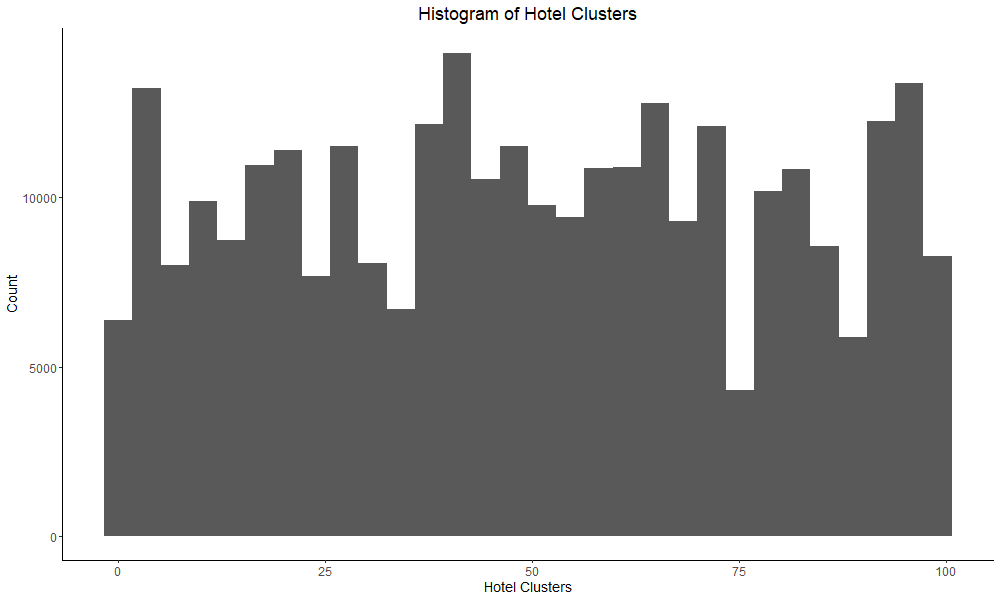

In [8]:
%%R -w 1000 -h 600 -u px
library(ggplot2)
library(ggthemes)
ggplot(train, aes(x=hotel_cluster)) + geom_histogram() + labs(x = "Hotel Clusters", y = "Count") + theme_classic() + ggtitle("Histogram of Hotel Clusters") + 
theme(plot.title = element_text(hjust = 0.5, size=18),
      axis.text=element_text(size=12),
     axis.title.x=element_text(size=14),
     axis.title.y=element_text(size=14))

As we can see, the distribution, while somewhat skewed, is fairly well distributed among the 100 different clusters.  

Next, let's look at the correlation between the variables to see what kinds of dependencies we might have.

In [9]:
%%R -i train

library(reshape2)
library(scales)
trainCor <- cor(train, use = "everything")
trainMelt <- melt(trainCor, varnames=c("x", "y"), value.name = "Correlation")
trainMelt <- trainMelt[order(trainMelt$Correlation), ]

C:\Users\jeffery.peterson.tm\AppData\Local\Continuum\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


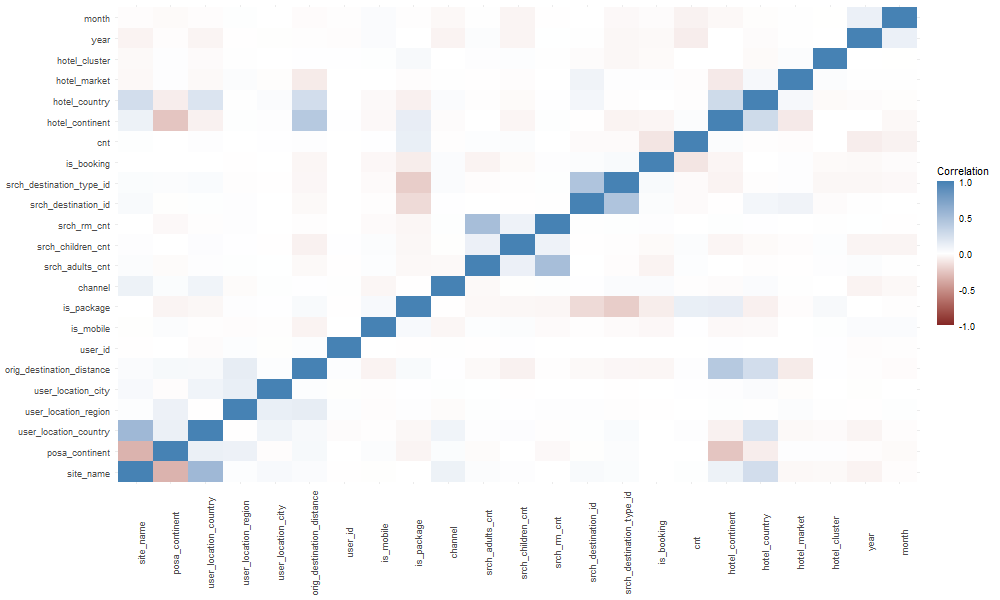

In [10]:
%%R -w 1000 -h 600 -u px
ggplot(trainMelt, aes(x=x, y=y)) + geom_tile(aes(fill=Correlation)) + scale_fill_gradient2(low = muted("red"), mid = "white", high = "steelblue", guide = guide_colorbar(ticks = FALSE, barheight = 10), limits=c(-1, 1)) + theme_minimal() + theme(axis.text.x = element_text(angle = 90)) + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

It doesn't appear that we have any strong linear dependencies between variables.  Just as a secondary confirmation, we can generate a correlation table.

In [11]:
train.corr()["hotel_cluster"]

site_name                   -0.027497
posa_continent               0.012180
user_location_country       -0.020239
user_location_region         0.006927
user_location_city           0.001241
orig_destination_distance    0.006084
user_id                      0.003891
is_mobile                    0.008788
is_package                   0.047598
channel                     -0.001386
srch_adults_cnt              0.012407
srch_children_cnt            0.014901
srch_rm_cnt                 -0.005570
srch_destination_id         -0.016736
srch_destination_type_id    -0.036120
is_booking                  -0.022898
cnt                          0.000378
hotel_continent              0.000422
hotel_country               -0.023837
hotel_market                 0.022149
hotel_cluster                1.000000
year                        -0.000435
month                       -0.002142
Name: hotel_cluster, dtype: float64

As suspected, our correlation table confirms what we saw in the correlation matrix.  We do not have anything that has a strong positive correlation to the hotel_cluster variable.  Therefore, linear models might not be the best option for these predictions.

# Merging of datasets

Before we can merge our train and destination datasets, we need to consider what variables are going to be critical when it comes to predicting a hotel cluster.  Based on the Kaggle descriptions of the variables, the following seem to be the most important:  
**srch_destination_id**:  this is the ID of the destination where the hotel search was performed.  
**hotel_country**:  this is the country where the hotel is located.  
**hotel_market**:  this is the market area where the hotel is located.  
**hotel_cluster**:  this is the ID of the hotel cluster.  **This is what we are going to predict**  
**is_booking**:  this is a binary choice of 1 if a hotel was booked, or 0 if it was just clicked on. 

Since we are only interested in hotels that were actually booked, we can eliminate the is_booking==0 values from our dataset.

In [12]:
train_booked = train.loc[train["is_booking"] == 1]

Next, we need to group our dataset according to the variables we defined as critical above.  This will tell us how many clusters were booked per srch_destination_id, hotel_country, hotel_market.

In [13]:
train_totals = [train.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
train_summary = pd.concat(train_totals).groupby(level=[0,1,2,3]).sum()
train_summary.dropna(inplace=True)
train_summary.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               0      1
                                               29               0      1
                                               30               0      1
                                               32               1      2
                                               43               0      1

In [14]:
train_summary['sum_and_count'] = 0.85*train_summary['sum'] + 0.15*train_summary['count']
train_summary = train_summary.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
train_summary.reset_index(inplace=True)
train_summary.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_count
0,4,7,246,22,0.0,0.125,0.073171
1,4,7,246,29,0.0,0.125,0.073171
2,4,7,246,30,0.0,0.125,0.073171
3,4,7,246,32,1.0,0.250,0.560976
4,4,7,246,43,0.0,0.125,0.073171


Now we can pivot our table so that it is in the proper format to merge with the `destination.csv` data.

In [15]:
train_pivot = train_summary.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_count').reset_index()
train_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,4,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.344828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's do the merge.

In [16]:
train_booked = pd.merge(train_booked, destinations, how='left', on='srch_destination_id')
train_booked = pd.merge(train_booked, train_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
train_booked.fillna(0, inplace=True)
train_booked.shape

(20032, 272)

In [17]:
train_booked.head(5)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,90,91,92,93,94,95,96,97,98,99
0,2,3,66,332,55121,2234.4394,160733,0,1,9,...,0.010283,0.000000,0.002571,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.005141
1,34,3,205,135,27655,234.6637,1194667,0,0,5,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,13,1,46,157,34868,612.4875,1160376,0,0,9,...,0.010125,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.028447,0.0,0.026037
3,2,3,66,337,6988,943.0843,1134956,0,0,2,...,0.011082,0.043272,0.001583,0.0,0.0,0.038522,0.021636,0.000000,0.0,0.001583
4,13,1,46,347,38786,611.3314,241627,0,0,9,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


# Algorithms

We first need to define what we will use for features (variables) and for labels (predictor).

In [18]:
x = train_booked.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = train_booked.hotel_cluster
x.shape, y.shape

((20032, 269), (20032,))

Things look good.  Let's pick our first algorithm.

## K-Nearest Neighbor (KNN)

In [19]:
import warnings
warnings.simplefilter("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

knn = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn_accuracy = np.mean(cross_val_score(knn, x, y, cv=10, scoring='accuracy'))
print("The accuracy of our KNN algorithm is:", knn_accuracy)

The accuracy of our KNN algorithm is: 0.2557704528693686


## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

lr = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
lr_accuracy = np.mean(cross_val_score(lr, x, y, cv=10))
print("The accuracy of our logistic regression algorithm is:", lr_accuracy)

The accuracy of our logistic regression algorithm is: 0.3042425172749558


## Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
rf_accuracy = np.mean(cross_val_score(rf, x, y, cv=10))
print("The accuracy of our random forest algorithm is:", rf_accuracy)

The accuracy of our random forest algorithm is: 0.2496716135408791


## Naive Bayes Classifier

In [22]:
from sklearn.naive_bayes import GaussianNB

nb = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
nb_accuracy = np.mean(cross_val_score(nb, x, y, cv=10))
print("The accuracy of our naive bayes algorithm is:", nb_accuracy)

The accuracy of our naive bayes algorithm is: 0.10338216278342642


## Algorithm Summary Table

| Algorithm | Accuracy Score |  
|-----------|----------------|  
| KNN | 25.6 % |  
| Logistic Regression | 30.4 % |  
| Random Forest | 25.0 % |  
| Naive Bayes | 10.3 % |  


**The logistic regression model was the most accurate.  
The KNN and Random Forest algorithms performed about the same.  
The Naive Bayes algorithm was the least accurate.**